# Task 2 — Wine Quality Classification with **LDA** (Final Notebook, English)

## Goal (as stated in the task)

In practice, “classify quality as correctly as possible” means:
- Build a reproducible ML pipeline
- Evaluate properly (train/test + cross-validation)
- **Use LDA** (required by the task / Lecture 2)
- Report results clearly (confusion matrix + classification report + CV scores)

---

## Plan
1. Load and inspect the **Wine Quality (white)** dataset
2. Create a **3-class target** (Lecture 2 style) for LDA:
   - **Low**: quality < 6
   - **Medium**: quality = 6
   - **High**: quality > 6
3. Visualize separation using **PCA(2D)** vs **LDA(2D)**
4. Train and compare LDA-based models:
   - LDA classifier (directly)
   - LDA → Logistic Regression
   - Regularized LDA (shrinkage)
   - Imbalance-aware variants: balanced priors / class_weight='balanced'
5. Select a final model and interpret results (submission-ready)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)

## 2) Load dataset

The dataset uses a semicolon separator `;`.

We use a *robust path search* so the notebook works even if your folder structure changes.


In [6]:
df = pd.read_csv("../../../datasets/raw/HW1/winequality-white.csv", sep=";")
print("Shape:", df.shape)
df.head()

Shape: (4898, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


## 3) Quick checks + Quality distribution (with counts)

We confirm:
- No missing values
- The original `quality` distribution is imbalanced

We annotate bars with **counts** so the plot is readable in a report.

Total missing values: 0


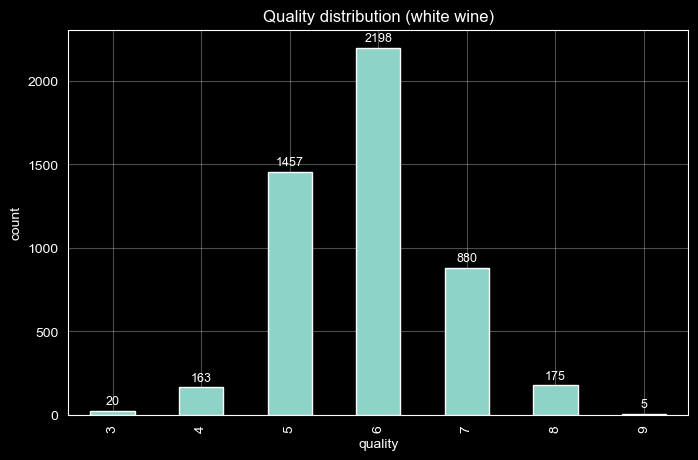

In [7]:
print("Total missing values:", df.isna().sum().sum())

counts = df["quality"].value_counts().sort_index()

plt.figure(figsize=(8, 5))
ax = counts.plot(kind="bar")
plt.xlabel("quality")
plt.ylabel("count")
plt.title("Quality distribution (white wine)")
plt.grid(True, alpha=0.3)

for i, v in enumerate(counts.values):
    ax.text(i, v + max(counts.values)*0.01, str(v), ha="center", va="bottom", fontsize=9)

plt.show()

## 4) Create a 3-class target (Lecture 2 style)

The original quality scores (3–9) are **ordinal** and **highly imbalanced**.

To make the classification task clearer (and to match the Lecture 2 methodology),
we group the scores into **three interpretable quality levels**:

- **0 = Low**: quality < 6
- **1 = Medium**: quality = 6
- **2 = High**: quality > 6

This creates **C = 3 classes**, so LDA can produce at most:

$$
n_{\text{components}} \le C - 1 = 2
$$

We will call this new target `quality3`.

Class counts (quality3): {0: 1640, 1: 2198, 2: 1060}


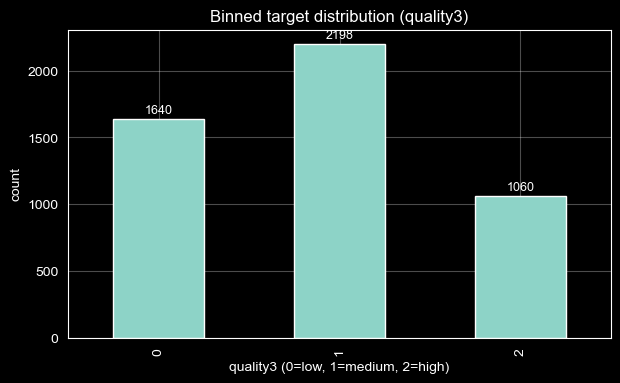

In [8]:
df["quality3"] = np.where(df["quality"] < 6, 0,
                 np.where(df["quality"] == 6, 1, 2))

print("Class counts (quality3):", df["quality3"].value_counts().sort_index().to_dict())

counts3 = df["quality3"].value_counts().sort_index()

plt.figure(figsize=(7, 4))
ax = counts3.plot(kind="bar")
plt.xlabel("quality3 (0=low, 1=medium, 2=high)")
plt.ylabel("count")
plt.title("Binned target distribution (quality3)")
plt.grid(True, alpha=0.3)

for i, v in enumerate(counts3.values):
    ax.text(i, v + max(counts3.values)*0.01, str(v), ha="center", va="bottom", fontsize=9)

plt.show()

## 5) Prepare X and y + why scaling matters

- `X` contains 11 physicochemical features
- `y = quality3` (0/1/2)

We scale features using StandardScaler.

For each feature column \(x\), StandardScaler computes:
- \(\mu\) (mu): the feature mean
- \(\sigma\) (sigma): the feature standard deviation

and transforms values into **z-scores**:

$$
z = \frac{x - \mu}{\sigma}
$$

This prevents large-unit features from dominating distance/variance-based methods.

In [10]:
X = df.drop(columns=["quality", "quality3"]).values
y = df["quality3"].values

print("X shape:", X.shape)
print("y classes:", np.unique(y))

X shape: (4898, 11)
y classes: [0 1 2]


## 6) PCA(2D) vs LDA(2D) — visual class separation

- **PCA** is unsupervised: it keeps directions of highest variance (ignores labels)
- **LDA** is supervised: it finds directions that separate classes

We project to 2D so we can compare the structure visually.

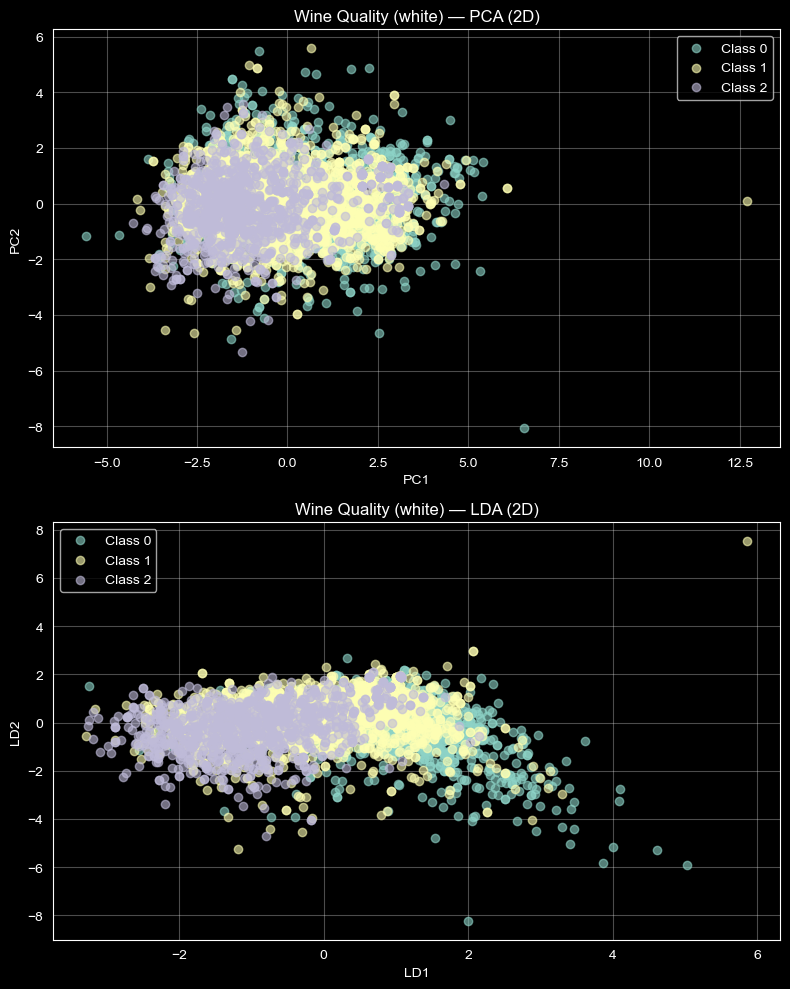

PCA explained variance ratio: [0.2929 0.1432]
PCA total (2D): 0.4361
LDA explained variance ratio: [0.9538 0.0462]
LDA total (2D): 1.0


In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X_scaled)

lda2 = LinearDiscriminantAnalysis(n_components=2)
X_lda2 = lda2.fit_transform(X_scaled, y)

plt.figure(figsize=(8, 10))

plt.subplot(2, 1, 1)
for cls in np.unique(y):
    plt.scatter(X_pca2[y == cls, 0], X_pca2[y == cls, 1], alpha=0.6, label=f"Class {cls}")
plt.title("Wine Quality (white) — PCA (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
for cls in np.unique(y):
    plt.scatter(X_lda2[y == cls, 0], X_lda2[y == cls, 1], alpha=0.6, label=f"Class {cls}")
plt.title("Wine Quality (white) — LDA (2D)")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("PCA explained variance ratio:", np.round(pca2.explained_variance_ratio_, 4))
print("PCA total (2D):", np.round(pca2.explained_variance_ratio_.sum(), 4))

print("LDA explained variance ratio:", np.round(lda2.explained_variance_ratio_, 4))
print("LDA total (2D):", np.round(lda2.explained_variance_ratio_.sum(), 4))

## 7) Evaluation setup: train/test split + repeated stratified CV

We use **two complementary evaluations**:

1) **Train/Test split**
   Gives a final, realistic estimate on held-out data.

2) **Repeated Stratified K-Fold cross-validation**
   - *Stratified*: preserves class proportions in each fold
   - *Repeated*: reduces variance from a “lucky/unlucky” split

We report:
- **Accuracy**
- **Balanced accuracy** (more fair under class imbalance)
- **Macro F1** (treats each class equally)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scoring = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "f1_macro": "f1_macro",
}

Train shape: (3428, 11)
Test shape : (1470, 11)


In [15]:
def evaluate_model(name, model):
    print(f"\n{'='*80}\n{name}\n{'='*80}")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    bal = balanced_accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")

    print("=== Test split ===")
    print(f"Accuracy         : {acc:.4f}")
    print(f"Balanced accuracy: {bal:.4f}")
    print(f"F1 (macro)       : {f1m:.4f}")

    print("\nClassification report:\n", classification_report(y_test, y_pred))
    print("Confusion matrix (rows=actual, cols=pred):")
    print(confusion_matrix(y_test, y_pred))

    cv_res = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    print("\n=== Cross-validation (mean ± std) ===")
    for k in scoring:
        vals = cv_res[f"test_{k}"]
        print(f"{k:18s}: {vals.mean():.4f} ± {vals.std():.4f}")

## 8) LDA-based models (required by the task)

We compare:

- **LDA classifier** (direct)
- **LDA → Logistic Regression**
- **Regularized LDA** using shrinkage (often helps when features correlate)
- Imbalance-aware variants:
  - **balanced priors** for LDA
  - **class_weight='balanced'** for Logistic Regression

In [19]:
C = len(np.unique(y))
uniform_priors = [1 / C] * C

models = {
    "A) LDA classifier (default priors)": Pipeline([
        ("scaler", StandardScaler()),
        ("lda", LinearDiscriminantAnalysis()),
    ]),
    "A2) LDA classifier (balanced priors)": Pipeline([
        ("scaler", StandardScaler()),
        ("lda", LinearDiscriminantAnalysis(priors=uniform_priors)),
    ]),
    "B) LDA(2) → LogisticRegression (default)": Pipeline([
        ("scaler", StandardScaler()),
        ("lda", LinearDiscriminantAnalysis(n_components=2)),
        ("logreg", LogisticRegression(max_iter=2000)),
    ]),
    "B2) LDA(2, balanced priors) → LogReg(class_weight='balanced')": Pipeline([
        ("scaler", StandardScaler()),
        ("lda", LinearDiscriminantAnalysis(n_components=2, priors=uniform_priors)),
        ("logreg", LogisticRegression(max_iter=2000, class_weight="balanced")),
    ]),
    "C) Regularized LDA (lsqr + shrinkage='auto')": Pipeline([
        ("scaler", StandardScaler()),
        ("lda", LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto")),
    ]),
}

for name, model in models.items():
    evaluate_model(name, model)


A) LDA classifier (default priors)
=== Test split ===
Accuracy         : 0.5796
Balanced accuracy: 0.5525
F1 (macro)       : 0.5647

Classification report:
               precision    recall  f1-score   support

           0       0.66      0.52      0.59       492
           1       0.54      0.68      0.60       660
           2       0.57      0.45      0.50       318

    accuracy                           0.58      1470
   macro avg       0.59      0.55      0.56      1470
weighted avg       0.59      0.58      0.58      1470

Confusion matrix (rows=actual, cols=pred):
[[258 220  14]
 [115 451  94]
 [ 15 160 143]]

=== Cross-validation (mean ± std) ===
accuracy          : 0.5721 ± 0.0182
balanced_accuracy : 0.5403 ± 0.0181
f1_macro          : 0.5526 ± 0.0188

A2) LDA classifier (balanced priors)
=== Test split ===
Accuracy         : 0.5252
Balanced accuracy: 0.5608
F1 (macro)       : 0.5266

Classification report:
               precision    recall  f1-score   support

          

## 9) Optional: GridSearchCV (still LDA-based)

To push performance further, we tune an LDA-based pipeline:

StandardScaler → LDA → LogisticRegression

We optimize **macro F1** by default (more “fair” under imbalance).
If your grading focuses strictly on “accuracy”, change `refit="accuracy"`.

In [18]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lda", LinearDiscriminantAnalysis()),
    ("logreg", LogisticRegression(max_iter=3000)),
])

param_grid = [
    # LDA as transformer: solver='svd' supports transform (no shrinkage here)
    {
        "lda__solver": ["svd"],
        "lda__n_components": [1, 2],          # for 3 classes, max is 2
        "logreg__C": [0.1, 1.0, 10.0],
        "logreg__class_weight": [None, "balanced"],
    },
    # Regularized LDA as transformer: use solver='eigen' (supports transform + shrinkage)
    {
        "lda__solver": ["eigen"],
        "lda__shrinkage": ["auto", 0.1, 0.5],
        "lda__n_components": [1, 2],
        "logreg__C": [0.1, 1.0, 10.0],
        "logreg__class_weight": [None, "balanced"],
    },
]

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=scoring,
    refit="f1_macro",   # change to "accuracy" if needed
    cv=cv,
    n_jobs=-1,
    verbose=0,
)

grid.fit(X, y)

print("Best params:", grid.best_params_)
print("Best CV score (refit metric):", grid.best_score_)

best_model = grid.best_estimator_
evaluate_model("Best tuned LDA-based pipeline (GridSearchCV)", best_model)

Best params: {'lda__n_components': 2, 'lda__solver': 'svd', 'logreg__C': 10.0, 'logreg__class_weight': None}
Best CV score (refit metric): 0.5398743531130579

Best tuned LDA-based pipeline (GridSearchCV)
=== Test split ===
Accuracy         : 0.5707
Balanced accuracy: 0.5332
F1 (macro)       : 0.5465

Classification report:
               precision    recall  f1-score   support

           0       0.66      0.53      0.59       492
           1       0.53      0.69      0.60       660
           2       0.56      0.37      0.45       318

    accuracy                           0.57      1470
   macro avg       0.58      0.53      0.55      1470
weighted avg       0.58      0.57      0.56      1470

Confusion matrix (rows=actual, cols=pred):
[[263 219  10]
 [119 458  83]
 [ 15 185 118]]

=== Cross-validation (mean ± std) ===
accuracy          : 0.5672 ± 0.0171
balanced_accuracy : 0.5281 ± 0.0175
f1_macro          : 0.5399 ± 0.0187
